Objective: To understand the relationship between environmental factors and human activity as recorded by IoT sensors.
Significance: Different environments contain various noise sources, impacting sensor performance. Analyzing sensor response across environments can aid in designing specific sensors, giving better intepretability for predictive modeling.

In [384]:
import pandas as pd

# Assuming you have downloaded the dataset and it's in CSV format
file_path = 'iot_telemetry_data.csv'  # Replace with the actual file path

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())

             ts             device        co   humidity  light       lpg  \
0  1.594512e+09  b8:27:eb:bf:9d:51  0.004956  51.000000  False  0.007651   
1  1.594512e+09  00:0f:00:70:91:0a  0.002840  76.000000  False  0.005114   
2  1.594512e+09  b8:27:eb:bf:9d:51  0.004976  50.900000  False  0.007673   
3  1.594512e+09  1c:bf:ce:15:ec:4d  0.004403  76.800003   True  0.007023   
4  1.594512e+09  b8:27:eb:bf:9d:51  0.004967  50.900000  False  0.007664   

   motion     smoke       temp  
0   False  0.020411  22.700000  
1   False  0.013275  19.700001  
2   False  0.020475  22.600000  
3   False  0.018628  27.000000  
4   False  0.020448  22.600000  


In [385]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
ts          0
device      0
co          0
humidity    0
light       0
lpg         0
motion      0
smoke       0
temp        0
dtype: int64


In [386]:
# Basic information about the dataset
print("\nDataset Info:")
data.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ts        405184 non-null  float64
 1   device    405184 non-null  object 
 2   co        405184 non-null  float64
 3   humidity  405184 non-null  float64
 4   light     405184 non-null  bool   
 5   lpg       405184 non-null  float64
 6   motion    405184 non-null  bool   
 7   smoke     405184 non-null  float64
 8   temp      405184 non-null  float64
dtypes: bool(2), float64(6), object(1)
memory usage: 22.4+ MB


Since the 'light' and 'motion' columns are boolean, we transform them into 0 and 1.

In [387]:
# Transforming boolean columns 'light' and 'motion' into integers
data['light'] = data['light'].astype(int)
data['motion'] = data['motion'].astype(int)

# convert unix time to time of day
from datetime import datetime, timedelta
start = datetime(1970, 1, 1)  # Unix epoch start time
data['datetime'] = data.ts.apply(lambda x: start + timedelta(seconds=x))
data = data.drop('ts', axis=1)

# Convert the 'datetime' column to a datetime object, and make datetime column into index column for convenience
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
data.head(5)

,device,co,humidity,light,lpg,motion,smoke,temp
datetime,,,,,,,,
2020-07-12 00:01:34.385975,b8:27:eb:bf:9d:51,0.004956,51.000000,0,0.007651,0,0.020411,22.700000
2020-07-12 00:01:34.735568,00:0f:00:70:91:0a,0.002840,76.000000,0,0.005114,0,0.013275,19.700001
2020-07-12 00:01:38.073573,b8:27:eb:bf:9d:51,0.004976,50.900000,0,0.007673,0,0.020475,22.600000
2020-07-12 00:01:39.589146,1c:bf:ce:15:ec:4d,0.004403,76.800003,1,0.007023,0,0.018628,27.000000
2020-07-12 00:01:41.761235,b8:27:eb:bf:9d:51,0.004967,50.900000,0,0.007664,0,0.020448,22.600000


In [388]:
# Grouping data by 'device' and creating a separate DataFrame for each device
device_groups = data.groupby('device')

# Dictionary to store each device's DataFrame
device_df = {}

for device, group in device_groups:
    device_df[device] = group

For a general overview, we plot them altogether with undersampling for quicker plotting.

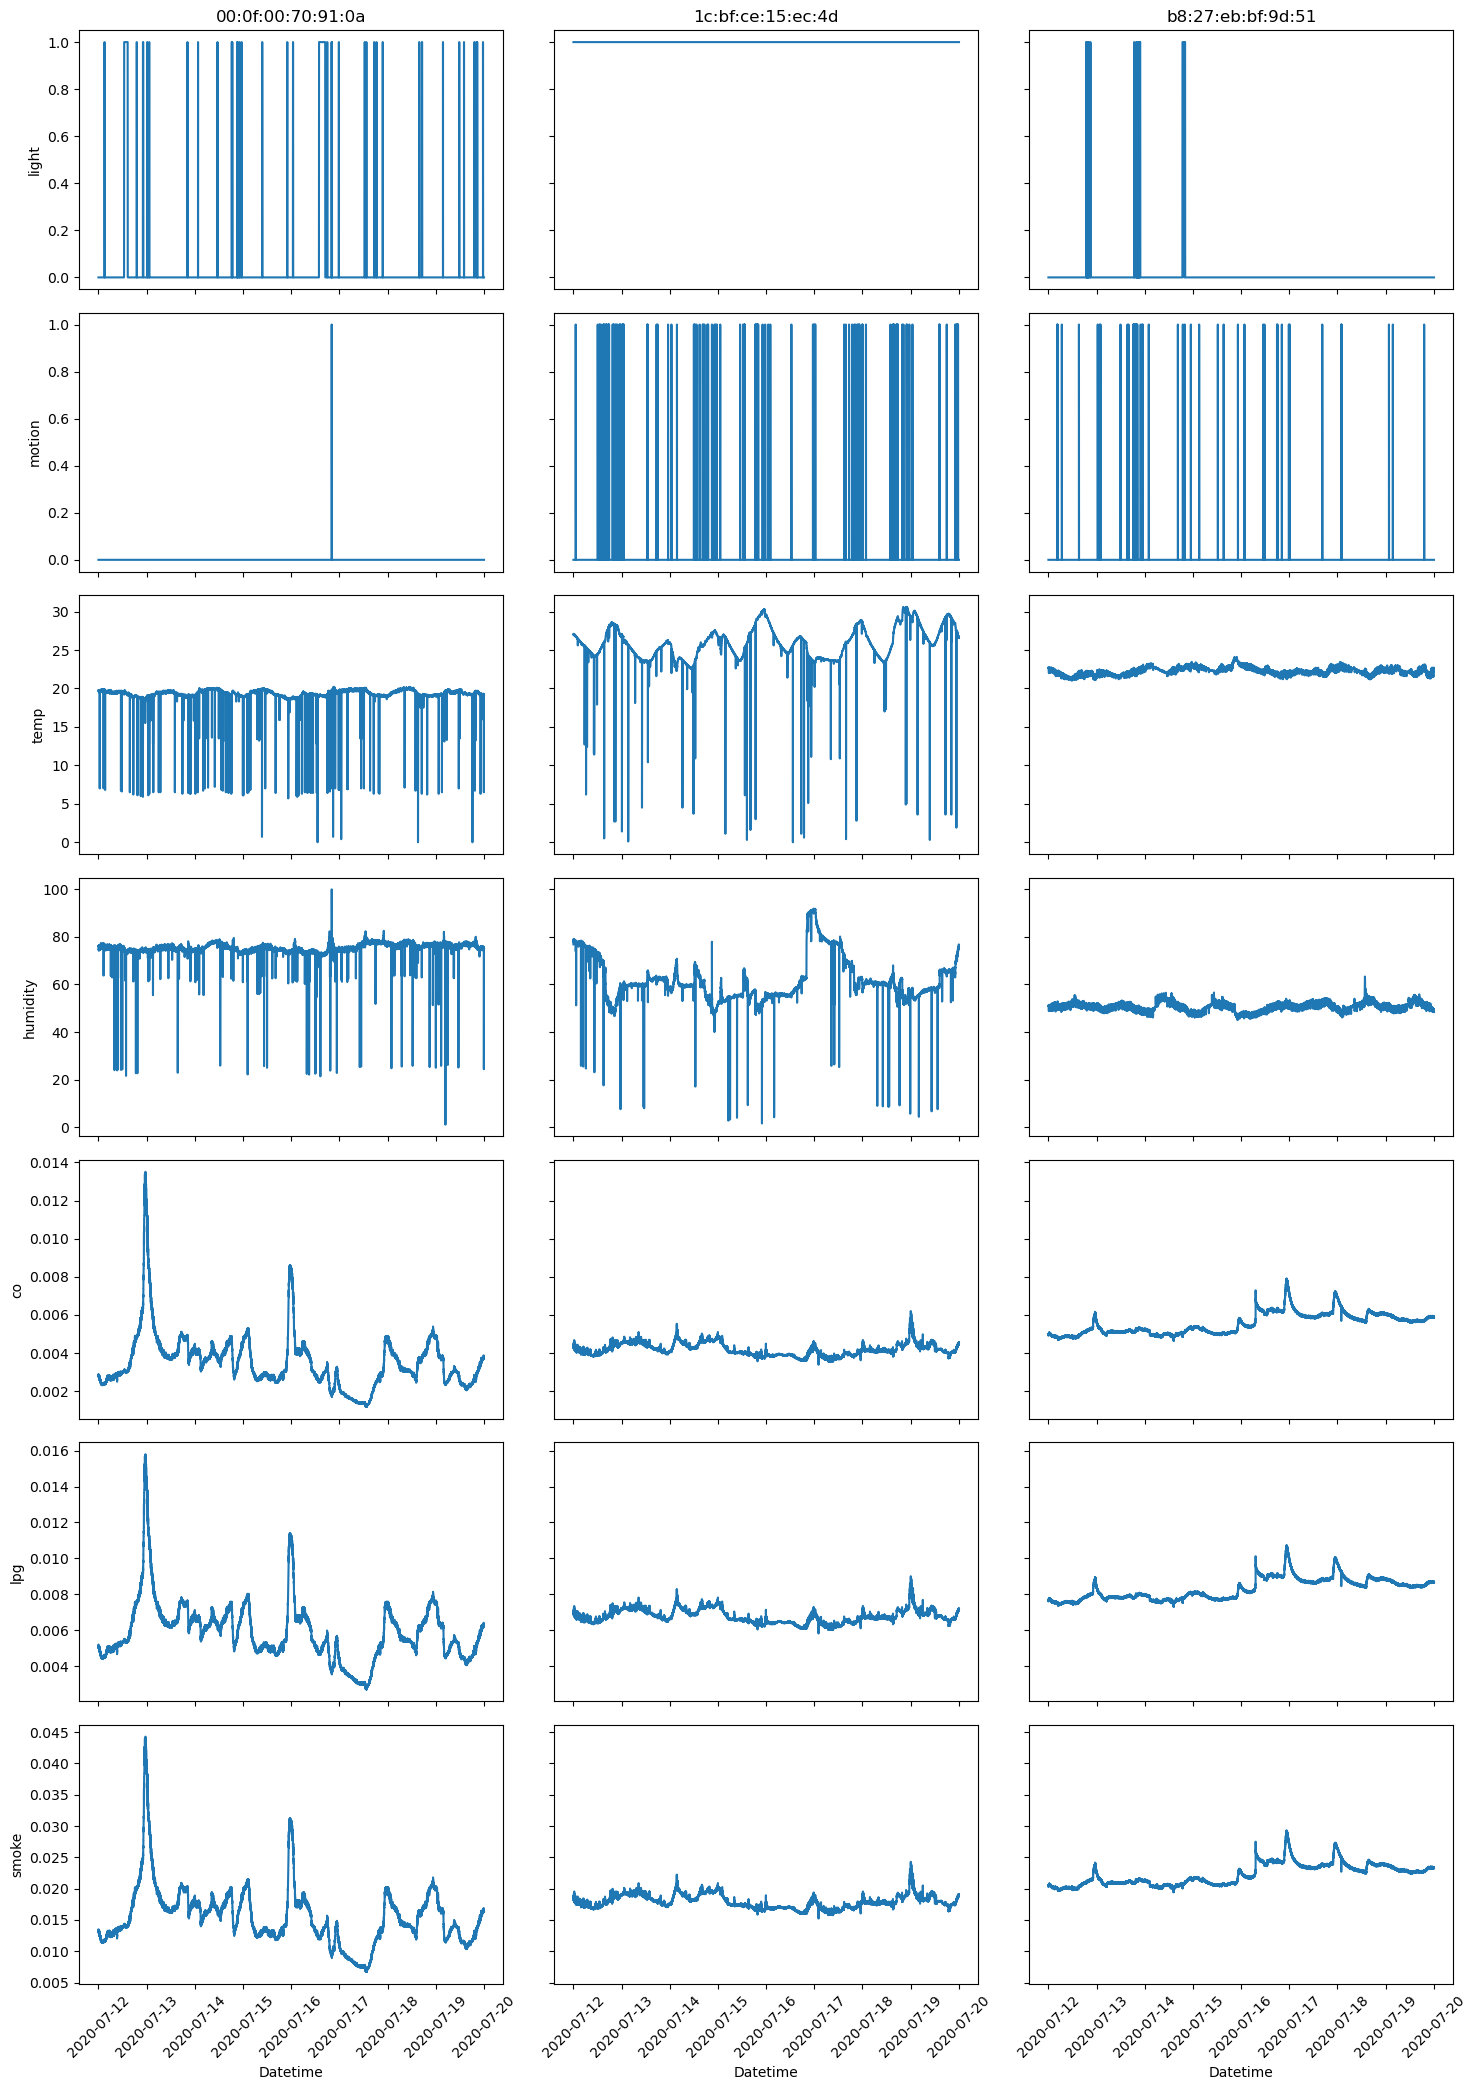

In [389]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_device_sensors(device_df, undersample_rate=1):
    """
    Plot sensor data for each device with aligned axes.

    Args:
    - device_df (dict): Dictionary with device IDs as keys and DataFrames as values.
    - undersample_rate (int): Rate at which to undersample the data for plotting efficiency. Default is 1 (no undersampling).
    """

    # Sensors in the desired order
    sensors = ['light', 'motion', 'temp', 'humidity', 'co', 'lpg', 'smoke']

    # Number of devices and sensors
    num_devices = len(device_df)
    num_sensors = len(sensors)

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=num_sensors, ncols=num_devices, figsize=(num_devices * 5, num_sensors * 3), sharex='col', sharey='row')

    # Iterate through each device and sensor
    for j, (device_id, df) in enumerate(device_df.items()):
        # Undersample the data
        df_undersampled = df.iloc[::undersample_rate, :]

        for i, sensor in enumerate(sensors):
            # Plot each sensor in a separate subplot
            sns.lineplot(data=df_undersampled, x=df_undersampled.index, y=sensor, ax=axes[i, j])
            axes[i, j].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

            # Set x and y labels
            if j == 0:  # Only set y-axis label for the first column
                axes[i, j].set_ylabel(sensor)
            if i == num_sensors - 1:  # Only set x-axis label for the bottom row
                axes[i, j].set_xlabel('Datetime')
            else:
                axes[i, j].set_xlabel('')

            # Set titles for the first row and first column
            if i == 0:
                axes[i, j].set_title(device_id)

    plt.tight_layout()
    plt.show()

# Example usage
plot_device_sensors(device_df, undersample_rate=2)  # Adjust undersample_rate as needed


CO, lpg, and smoke readout are highly correlated.
To confirm the correlation, we plot the correlation matrix to verify this observation.

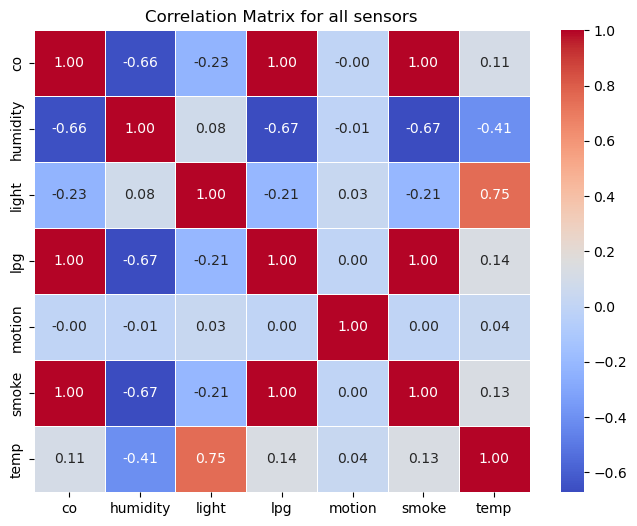

In [390]:
# Drop the sensor column
corr_data = data.drop(['device'],axis=1)

# Compute the correlation matrix
corr_matrix = corr_data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for all sensors')
plt.show()


The strong correlation is verified, so we remove lpg and smoke as they do not provide new information.

In [391]:
# Iterating through the dictionary and removing 'lpg' and 'smoke' columns
for device_id, df in device_df.items():
    device_df[device_id] = df.drop(columns=['lpg', 'smoke'])

device_df

{'00:0f:00:70:91:0a':                                        device        co   humidity  light  \
 datetime                                                                    
 2020-07-12 00:01:34.735568  00:0f:00:70:91:0a  0.002840  76.000000      0   
 2020-07-12 00:01:46.869076  00:0f:00:70:91:0a  0.002938  76.000000      0   
 2020-07-12 00:02:02.785732  00:0f:00:70:91:0a  0.002905  75.800003      0   
 2020-07-12 00:02:11.476376  00:0f:00:70:91:0a  0.002938  75.800003      0   
 2020-07-12 00:02:15.289086  00:0f:00:70:91:0a  0.002840  76.000000      0   
 ...                                       ...       ...        ...    ...   
 2020-07-20 00:03:16.329782  00:0f:00:70:91:0a  0.003745  75.300003      0   
 2020-07-20 00:03:20.684223  00:0f:00:70:91:0a  0.003745  75.400002      0   
 2020-07-20 00:03:25.039890  00:0f:00:70:91:0a  0.003745  75.400002      0   
 2020-07-20 00:03:33.162015  00:0f:00:70:91:0a  0.003745  75.300003      0   
 2020-07-20 00:03:36.979522  00:0f:00:70:91

In this grouped data, we can find that these several devices have different sampling rate, so we will calculate them here for later use.

In [392]:
# Function that calculate the sampling rate
def calculate_sampling_stats(device_df):
    sampling_stats = {}

    for device_id, df in device_df.items():
        # Calculate time differences between consecutive data points
        time_diffs = df.index.to_series().diff().dropna()

        # Convert time differences to a consistent unit, e.g., seconds
        time_diffs_in_seconds = time_diffs.dt.total_seconds()

        # Calculate mean and standard deviation
        mean_sampling_rate = time_diffs_in_seconds.mean()
        std_sampling_rate = time_diffs_in_seconds.std()

        # Store in dictionary
        sampling_stats[device_id] = {'mean': mean_sampling_rate, 'std': std_sampling_rate}

    return sampling_stats

# Calculate sampling stats for each device
device_sampling_stats = calculate_sampling_stats(device_df)
for device, stats in device_sampling_stats.items():
    print(f"Device {device} - Mean Sampling Rate: {stats['mean']}s, Std Dev: {stats['std']}s")


Device 00:0f:00:70:91:0a - Mean Sampling Rate: 6.182787879460532s, Std Dev: 2.536354069027526s
Device 1c:bf:ce:15:ec:4d - Mean Sampling Rate: 6.526965254047981s, Std Dev: 3.0185357592392035s
Device b8:27:eb:bf:9d:51 - Mean Sampling Rate: 3.6880388281568415s, Std Dev: 0.052234523971958435s


Now we check the temperature and humidity of each device to see if they match with the dataset description.

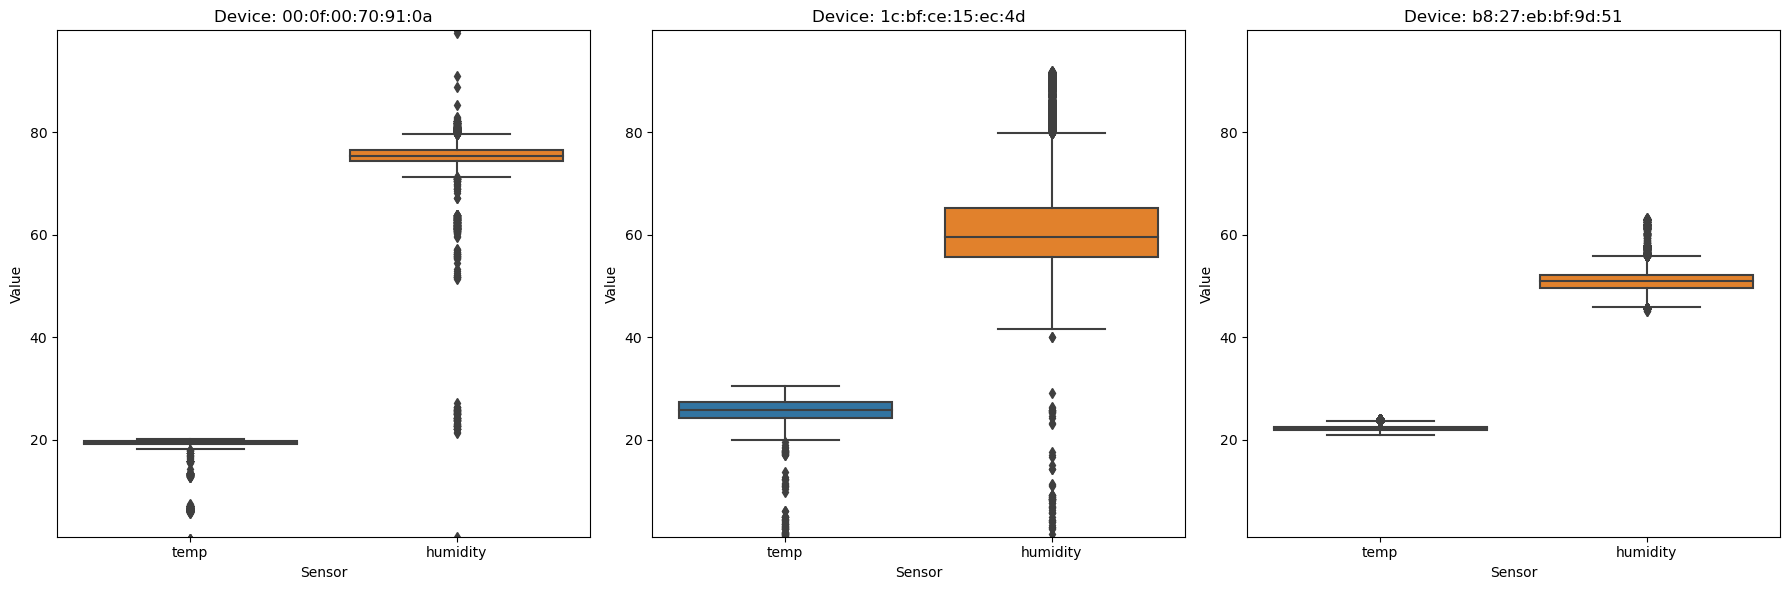

In [393]:
def plot_sensor_boxplots(device_df, sensors=['temp', 'humidity']):
    """
    Generate box plots for specified sensors from each device with same y-axis scale.

    Args:
    - device_df (dict): Dictionary with device IDs as keys and DataFrames as values.
    - sensors (list): List of sensors to plot.
    """

    num_devices = len(device_df)
    fig, axes = plt.subplots(nrows=1, ncols=num_devices, figsize=(num_devices * 6, 6))

    # Determine the global min and max values across all devices for each sensor
    global_min = {sensor: float('inf') for sensor in sensors}
    global_max = {sensor: float('-inf') for sensor in sensors}

    for df in device_df.values():
        for sensor in sensors:
            global_min[sensor] = min(global_min[sensor], df[sensor].min())
            global_max[sensor] = max(global_max[sensor], df[sensor].max())

    # Plot the box plots
    for j, (device_id, df) in enumerate(device_df.items()):
        data_to_plot = df[sensors].melt(var_name='Sensor', value_name='Value')
        sns.boxplot(x='Sensor', y='Value', data=data_to_plot, ax=axes[j])
        axes[j].set_title(f'Device: {device_id}')

        # Set the same y-axis limits for each subplot
        for i, sensor in enumerate(sensors):
            axes[j].set_ylim([global_min[sensor], global_max[sensor]])

    plt.tight_layout()
    plt.show()

# Example usage
plot_sensor_boxplots(device_df)


Consistent with the dataset's description, it is evident that the three devices are situated in distinct environments, each characterized by unique temperature and humidity profiles.

Device 00: This environment is cool and humid, indicative of a well-controlled indoor setting. Such conditions suggest a stable and consistent environmental management system.
Device 1c: This environment is warm and moderately humid, and with significant variation. The fluctuating readings point towards an outdoor or semi-outdoor setting, where temperature and humidity are subject to natural variations.
Device b8: This environment is warm and dry, and it also appears to be well-controlled. The consistent readings suggest an indoor location, similar to Device 00, but with a notably different climate control setup.

These observations lead to a preliminary hypothesis: Devices 00 and b8 are likely situated indoors, given their stable environmental readings. In contrast, Device 1c, with its more variable data, seems to be positioned outdoors or in a semi-outdoor environment. However, confirming this hypothesis necessitates further analysis, particularly a detailed examination of daily readouts.

Moving forward, our analysis shifts focus to the motion and light sensor readouts. Given the binary nature of this data, which does not readily convey the intensity of sensor activity, we will implement a rolling average. This approach will smooth out the data epochs, transforming the binary readouts into a more continuous and interpretable measure of sensor activity frequency. Such a transformation is crucial for a more nuanced understanding of the environmental dynamics captured by these sensors.

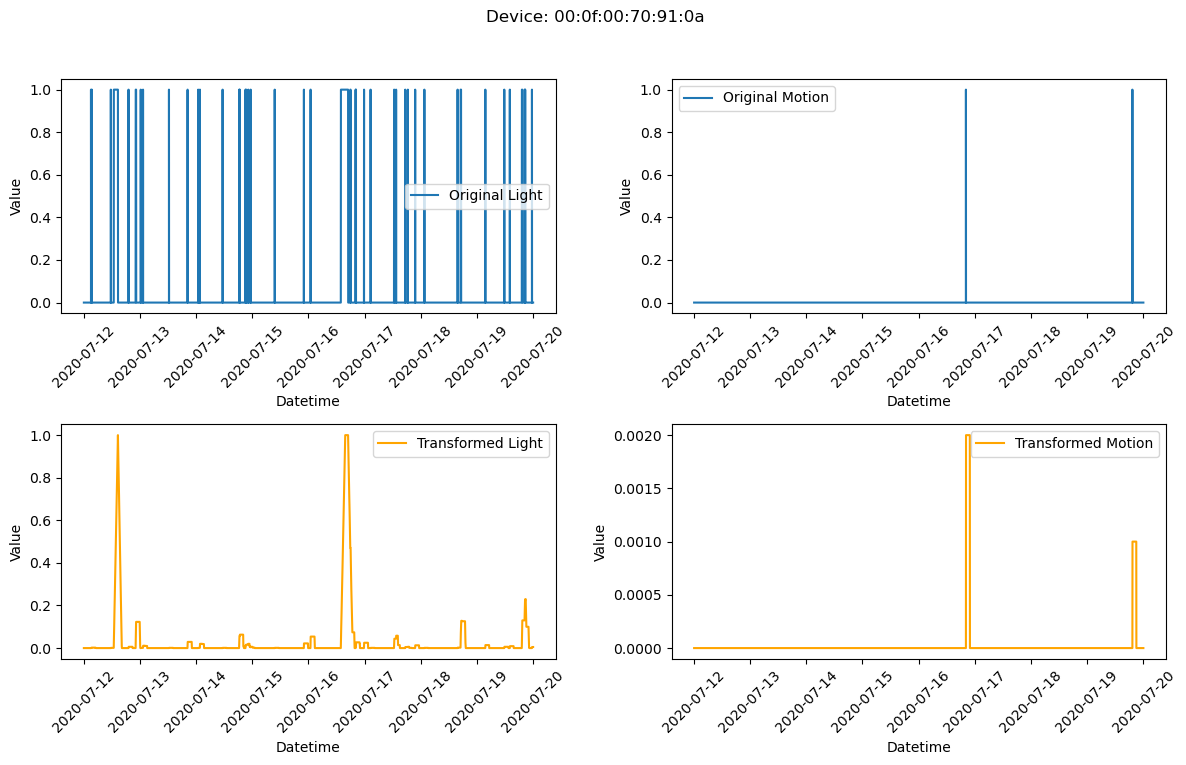

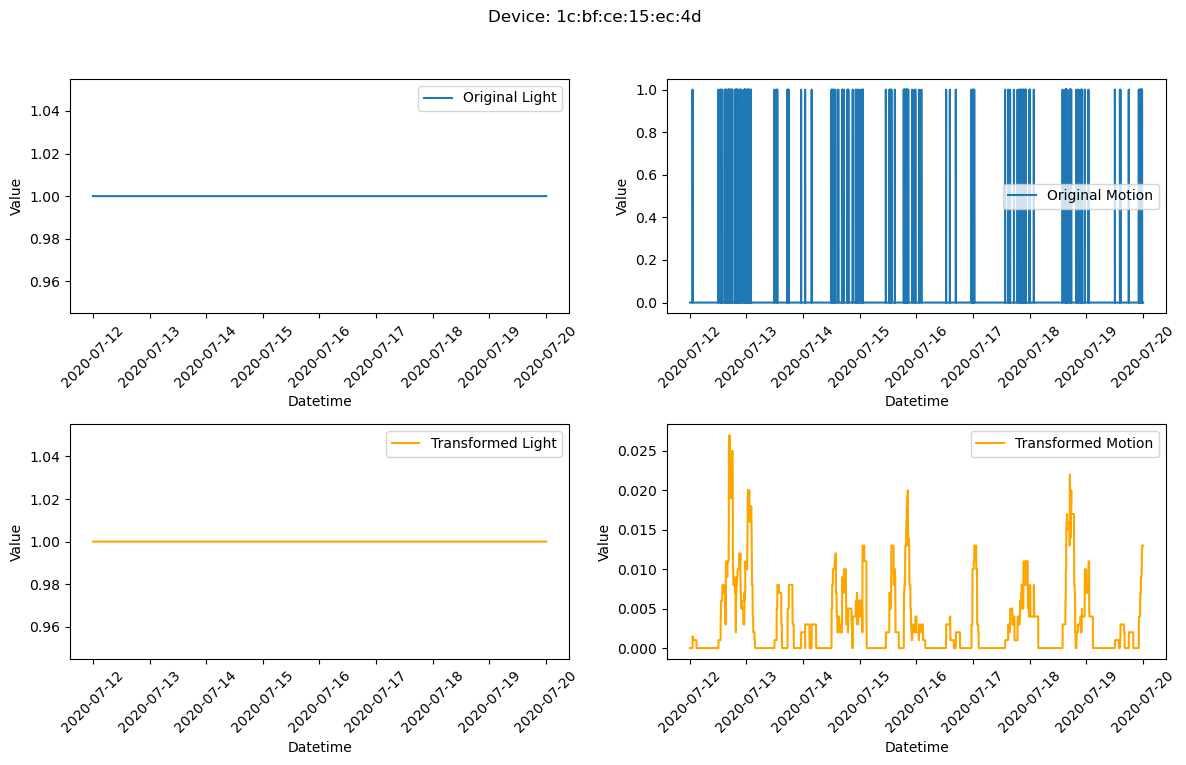

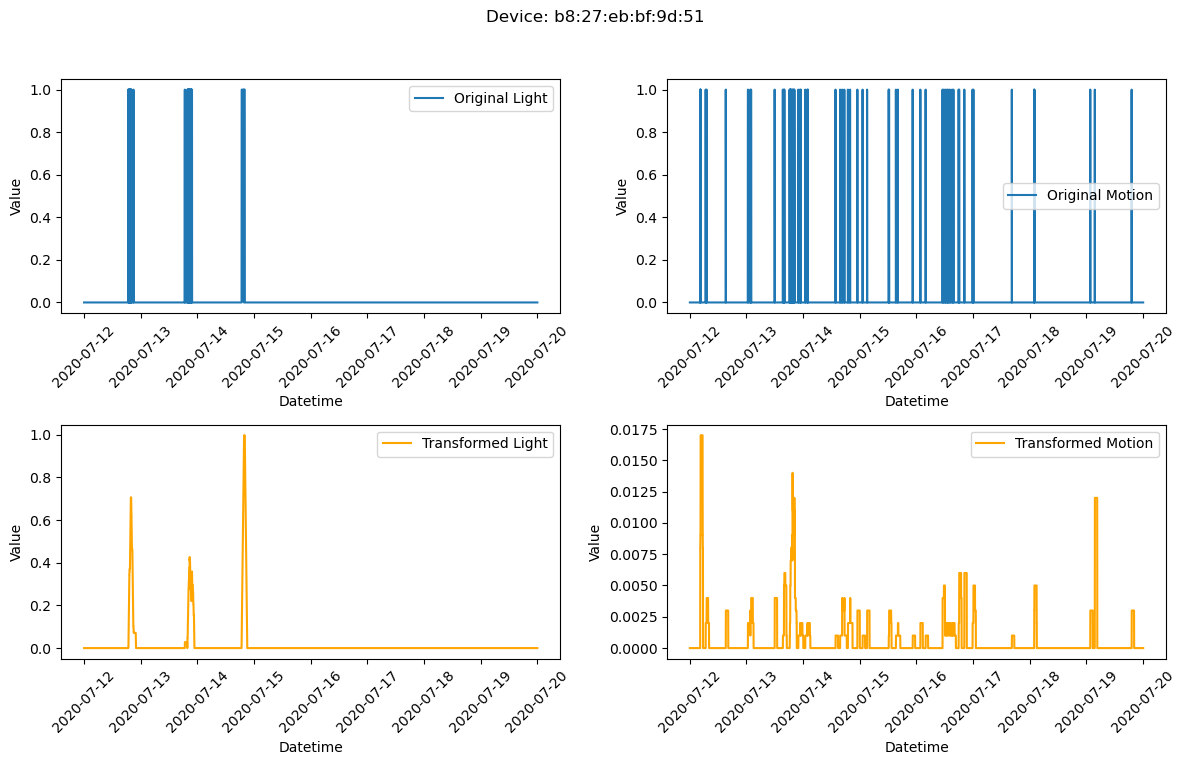

In [394]:
def transform_binary_to_frequency(df, window_size):
    """
    Transform binary signals to frequency rates using rolling window mean.

    Args:
    - df (DataFrame): DataFrame containing binary signals.
    - window_size (int): Size of the rolling window.

    Returns:
    - DataFrame: Transformed DataFrame.
    """
    df_transformed = df.rolling(window=window_size, min_periods=1).mean()
    return df_transformed

def plot_transformed_data(device_df, window_size):
    """
    Plot original and transformed binary signals.

    Args:
    - device_df (dict): Dictionary with device IDs as keys and DataFrames as values.
    - window_size (int): Size of the rolling window for transformation.
    """

    for device_id, df in device_df.items():
        # Transform binary signals
        df_transformed = transform_binary_to_frequency(df[['light', 'motion']], window_size)

        # Plotting
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
        fig.suptitle(f"Device: {device_id}")

        # Original Data
        axes[0, 0].plot(df.index, df['light'], label='Original Light')
        axes[0, 1].plot(df.index, df['motion'], label='Original Motion')

        # Transformed Data
        axes[1, 0].plot(df_transformed.index, df_transformed['light'], label='Transformed Light', color='orange')
        axes[1, 1].plot(df_transformed.index, df_transformed['motion'], label='Transformed Motion', color='orange')

        # Setting labels
        for i in range(2):
            for j in range(2):
                axes[i, j].set_xlabel('Datetime')
                axes[i, j].set_ylabel('Value')
                axes[i, j].legend()
                axes[i, j].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Example usage
window_size = 1000 # Example window size, adjust as needed
plot_transformed_data(device_df, window_size)


The graphs display the light and motion sensor data before and after applying a rolling average, transforming the data from binary to a continuous format. This transformed data is then reintegrated into the original grouped dataframe.

Next, we utilize the previously calculated sampling rates to generate autocorrelation plots so that we can observe the seasonal patterns within the dataset.

/Users/chaozhuang/anaconda3/lib/python3.11/site-packages/pandas/plotting/_matplotlib/misc.py:458: RuntimeWarning: invalid value encountered in scalar divide
  return ((data[: n - h] - mean) * (data[h:] - mean)).sum() / n / c0


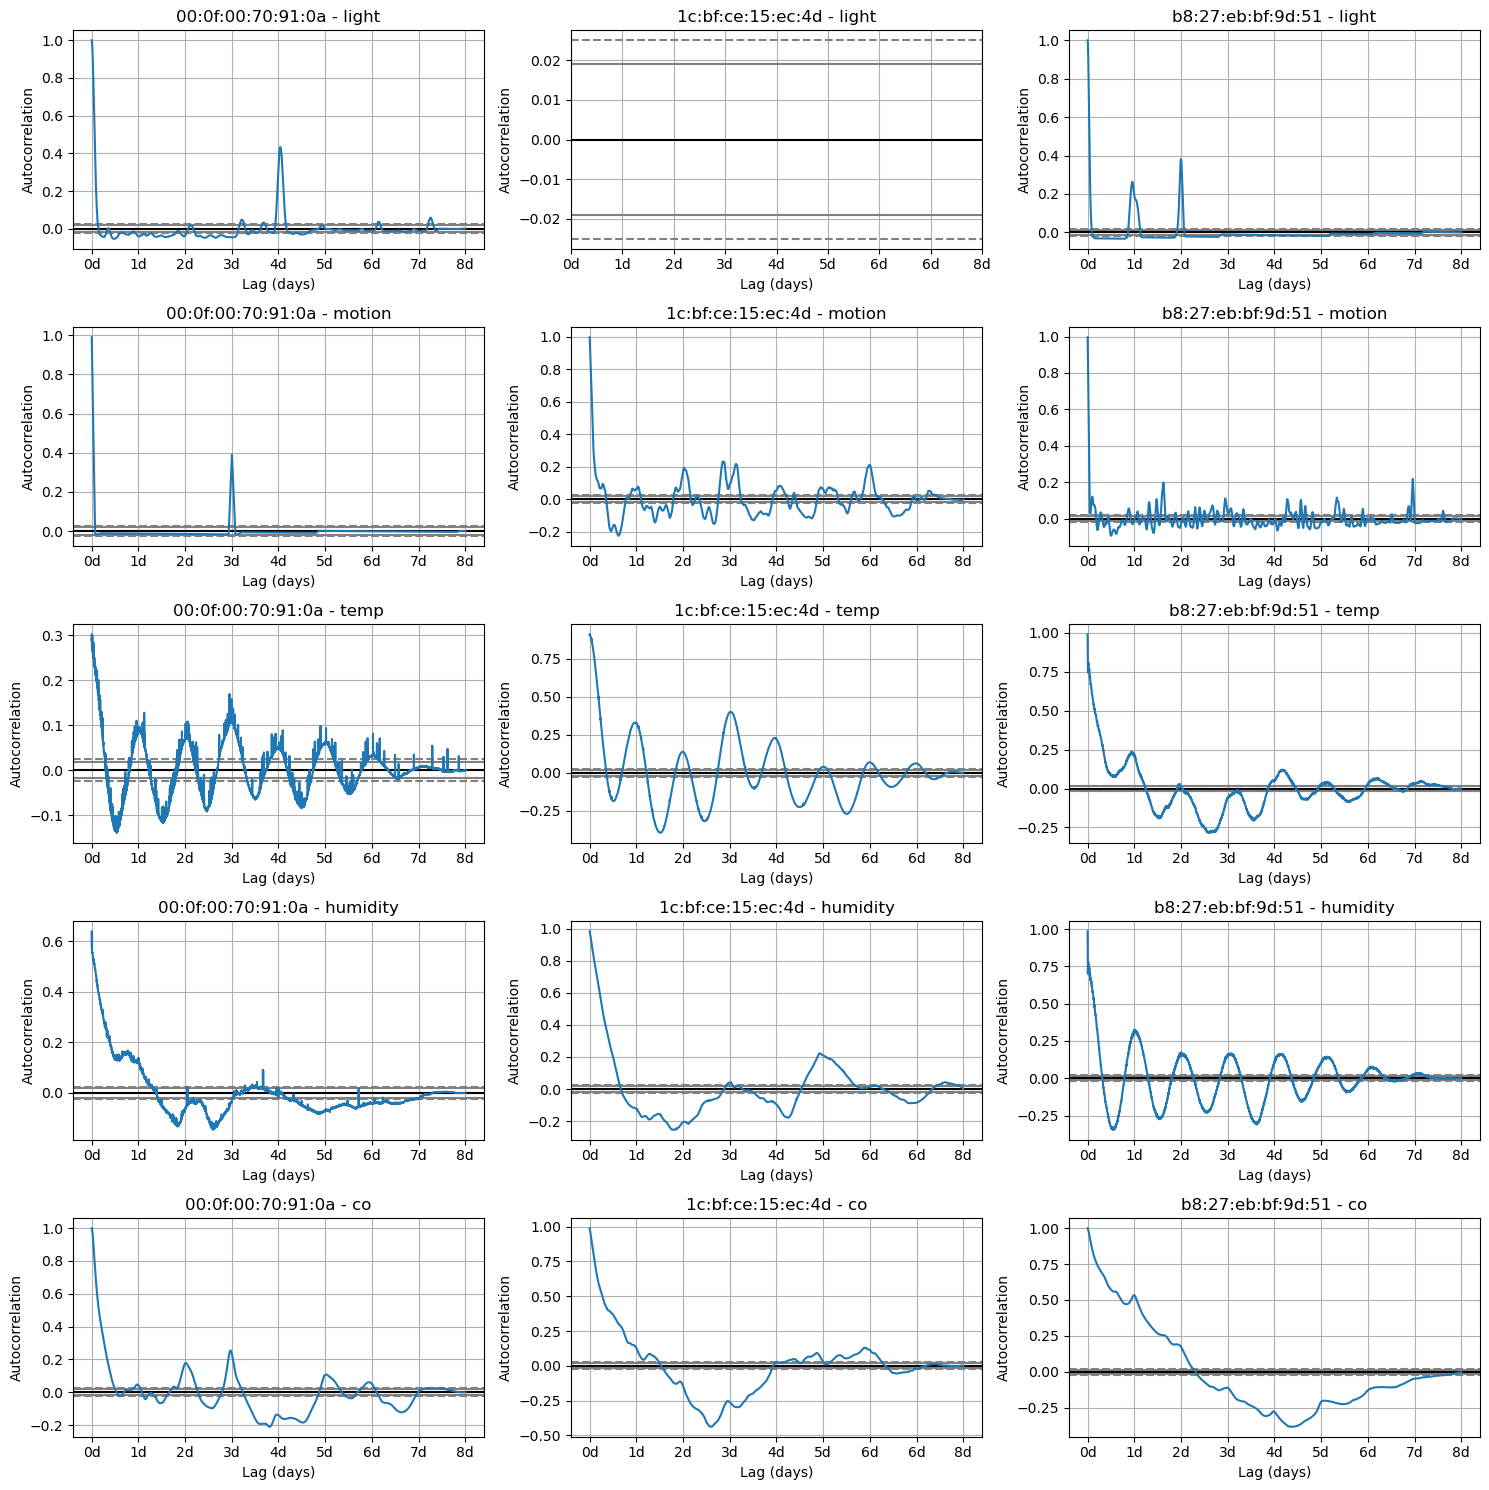

In [395]:
from pandas.plotting import autocorrelation_plot
import numpy as np

def plot_autocorrelation(device_df, undersample_rate=1, sampling_rates=None):
    """
    Generate autocorrelation plots for all sensors in all devices.

    Args:
    - device_df (dict): Dictionary with device IDs as keys and DataFrames as values.
    - undersample_rate (int): Rate at which to undersample the data for plotting efficiency.
    - sampling_rates (dict): Dictionary with device IDs as keys and average sampling rates as values.
    """

    # Sensors in the desired order
    sensors = ['light', 'motion', 'temp', 'humidity', 'co']

    # Number of devices and sensors
    num_devices = len(device_df)
    num_sensors = len(sensors)

    # Seconds in a day
    seconds_in_day = 24 * 60 * 60

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=num_sensors, ncols=num_devices, figsize=(num_devices * 5, num_sensors * 3))

    # Iterate through each device and sensor
    for j, (device_id, df) in enumerate(device_df.items()):
        # Calculate number of samples in a day
        samples_per_day = seconds_in_day / (sampling_rates[device_id] * undersample_rate)
        
        # Undersample the data
        df_undersampled = df.iloc[::undersample_rate, :]

        for i, sensor in enumerate(sensors):
            # Create autocorrelation plot for each sensor
            autocorrelation_plot(df_undersampled[sensor], ax=axes[i][j])
            axes[i][j].set_title(f'{device_id} - {sensor}')
            axes[i][j].set_xlabel('Lag (days)')
            axes[i][j].set_ylabel('Autocorrelation')

            # Adjust x-axis to represent days
            max_lag = df_undersampled[sensor].shape[0]
            xticks = np.arange(0, max_lag, samples_per_day)
            xticklabels = [f"{int(lag/samples_per_day)}d" for lag in xticks]
            axes[i][j].set_xticks(xticks)
            axes[i][j].set_xticklabels(xticklabels)

    plt.tight_layout()
    plt.show()

# Apply the transformation to binary data
window_size = 1000
for device_id in device_df:
    device_df[device_id][['light', 'motion']] = transform_binary_to_frequency(device_df[device_id][['light', 'motion']], window_size)

# Sampling rates for each device
sampling_rates = {
    '00:0f:00:70:91:0a': 6.182787879460532,
    '1c:bf:ce:15:ec:4d': 6.526965254047981,
    'b8:27:eb:bf:9d:51': 3.6880388281568415
}

plot_autocorrelation(device_df, undersample_rate=10, sampling_rates=sampling_rates)


All temperature sensors exhibit a daily seasonality, but with varying intensities. Notably, Device 1c demonstrates the strongest seasonality, characterized by high correlation factors and signal-to-noise ratios. This suggests that the environment where Device 1c is located is significantly influenced by daily temperature variations.

Furthermore, the motion sensor readings in the Device 1c environment align with this daily periodicity, a pattern not observed in the other two devices.

In terms of humidity, each environment presents distinct trends. The Device 00 environment shows no notable daily seasonality, Device 1c exhibits a bi-daily pattern, while Device b8 experiences daily fluctuations.

Given the observed daily patterns in these sensor readings, plotting and overlaying the daily variations across devices could reveal overarching trends and environmental characteristics.

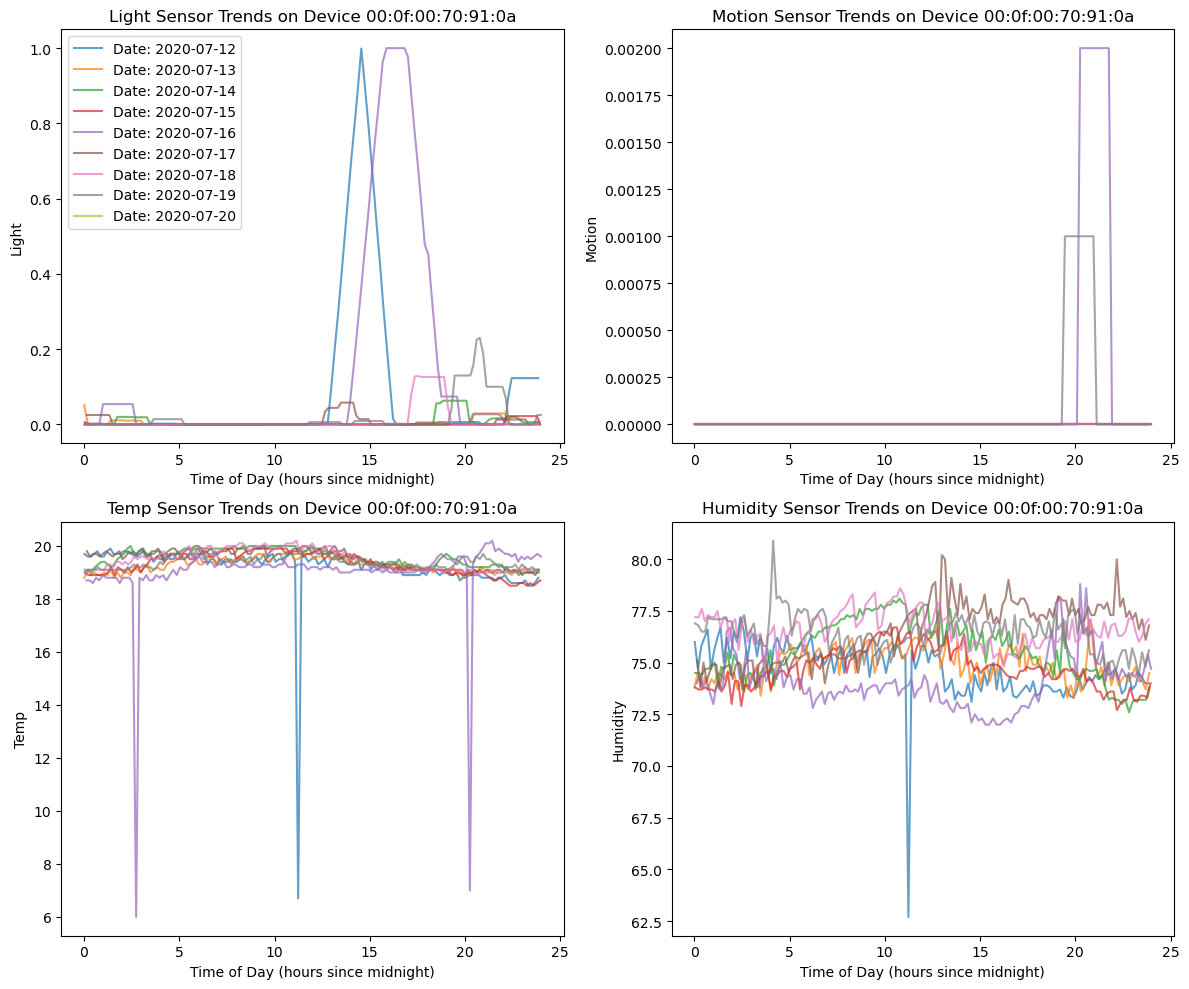

In [396]:
import matplotlib.pyplot as plt
import pandas as pd

def convert_time_to_hours(time_obj):
    """
    Convert a time object to hours since midnight.

    Args:
    - time_obj (datetime.time): Time object to convert.

    Returns:
    - float: Number of hours since midnight.
    """
    return time_obj.hour + time_obj.minute / 60 + time_obj.second / 3600

def plot_daily_trends_for_sensors(device_df, device_id, sensors, undersample_rate=100, window_size=1):
    """
    Plot daily trends of multiple sensors from a device in a 2x2 matrix with legends indicating dates.

    Args:
    - device_df (dict): Dictionary with device IDs as keys and DataFrames as values.
    - device_id (str): The ID of the device to plot.
    - sensors (list): List of sensors to plot.
    - undersample_rate (int): Rate at which to undersample the data.
    - window_size (int): Window size for moving average.
    """
    df = device_df[device_id]

    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, sensor in enumerate(sensors):
        # Undersample and apply moving average
        df_resampled = df.iloc[::undersample_rate, :]
        df_smoothed = df_resampled[sensor].rolling(window=window_size, min_periods=1).mean()

        # Group by date and plot each day's data
        for date, group in df_smoothed.groupby(df_smoothed.index.date):
            # Convert index time to hours
            hours_since_midnight = [convert_time_to_hours(t) for t in group.index.time]
            axes[i].plot(hours_since_midnight, group, alpha=0.7, label=f'Date: {date}')

        axes[i].set_title(f'{sensor.capitalize()} Sensor Trends on Device {device_id}')
        axes[i].set_xlabel('Time of Day (hours since midnight)')
        axes[i].set_ylabel(f'{sensor.capitalize()}')
        if i == 0:
            axes[i].legend()

    # Adjust layout and show plot
    fig.tight_layout()
    plt.show()

# Example usage
sensors = ['light', 'motion', 'temp', 'humidity']
plot_daily_trends_for_sensors(device_df, '00:0f:00:70:91:0a', sensors)


Consistent with our previous observations, the temperature and humidity in the Device 00 environment appear to be well-controlled. Furthermore, light and motion activities are predominantly observed during nighttime, providing additional evidence to support the hypothesis that this environment is likely indoors.

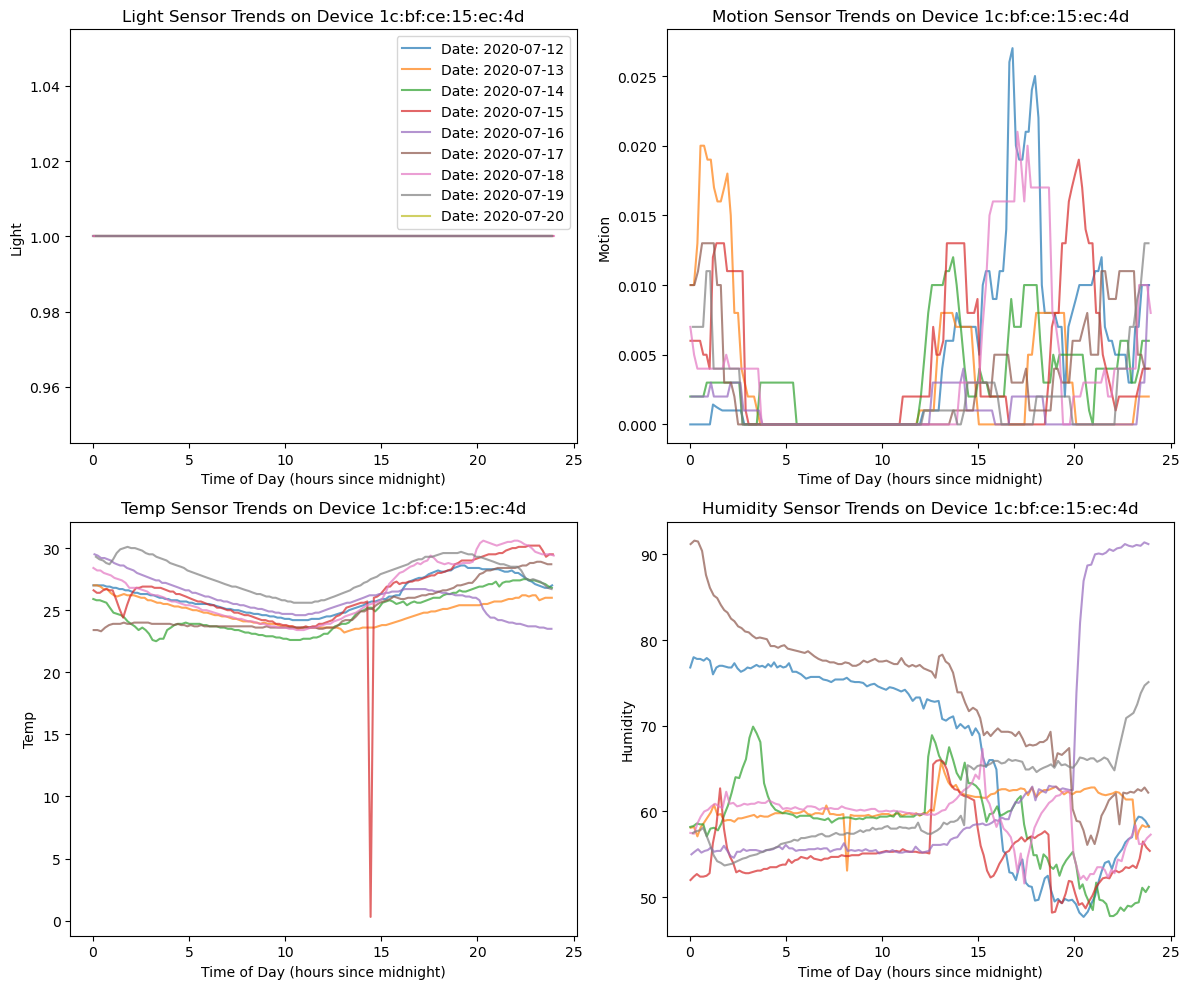

In [397]:
plot_daily_trends_for_sensors(device_df, '1c:bf:ce:15:ec:4d', sensors)

Device 1c presents a contrasting pattern to Device 00, exhibiting clear daily temperature variations with the coolest temperatures at noon and the warmest at night. Additionally, humidity levels are relatively high during the day but plummet to minimal levels in the evening.

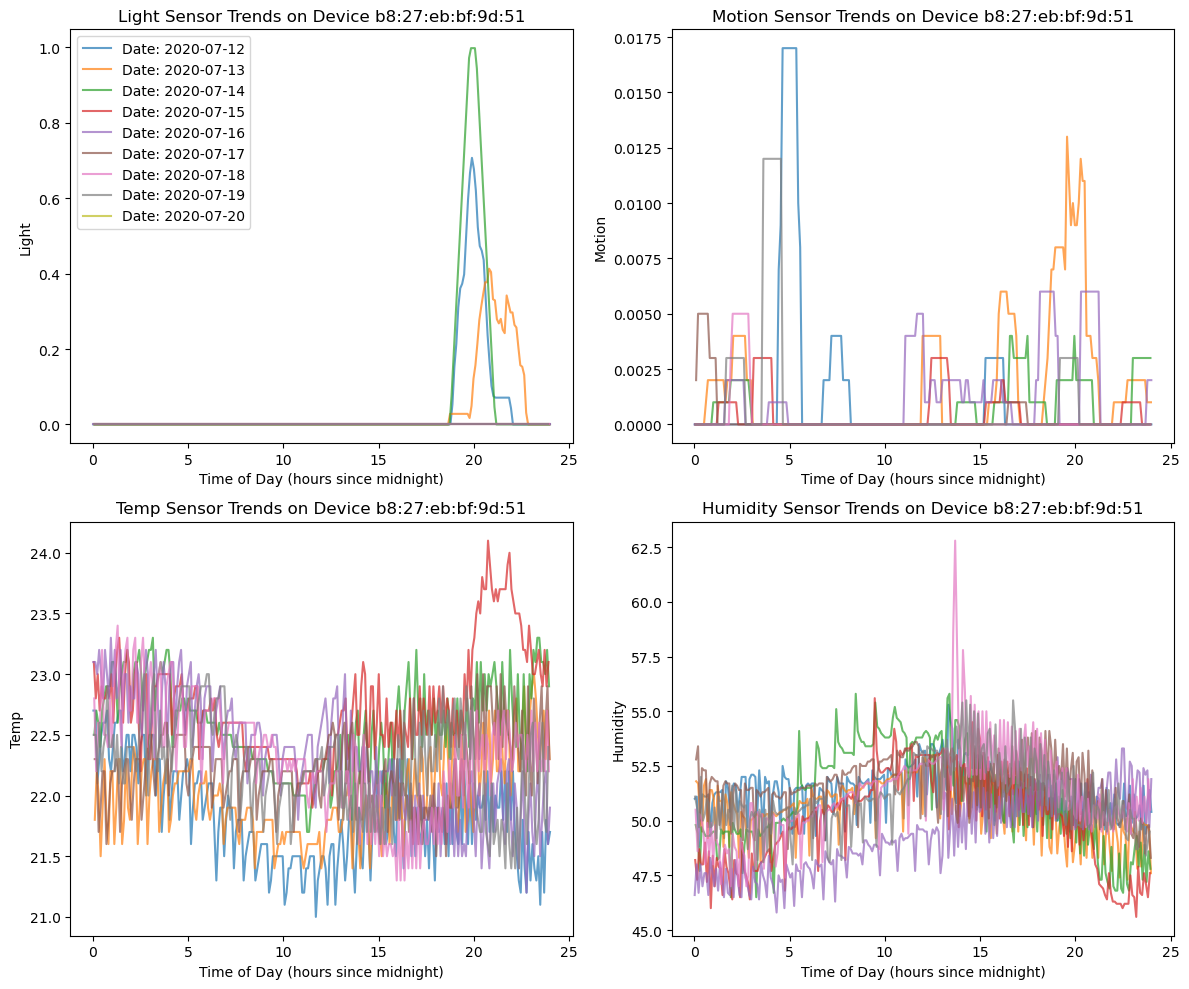

In [398]:
plot_daily_trends_for_sensors(device_df, 'b8:27:eb:bf:9d:51', sensors)

The environmental stability of Device b8 mirrors that of Device 00. Device b8 displays a daily temperature pattern, characterized by a high frequency of features distinct from the high-intensity peaks observed in the other two devices. A similar pattern is noted in the humidity readings. This suggests that the devices might either contain different temperature and humidity sensors, or that they are exposed to varying environmental noises, such as vibrations from sudden human activity or machinery.

The light and motion sensor readings further indicate that human activity tends to avoid noon, concentrating instead during the afternoon and nighttime.

Next Steps: With the detailed knowledge about the daily trends, we can next analyze the sources of high-frequency noise and random intense noise to determine their correlation with human activity. This insight could enable the development of an unsupervised learning model, such as PCA, to cluster and classify different environments.